## Library

In [ ]:
import os
import cv2
import random
import tifffile as tiff
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split

In [ ]:
%config IPCompleter.greedy=True

## Dataset

In [ ]:
large_image_stack = tiff.imread('./../Datasets/mitochondria/training.tif')
large_mask_stack = tiff.imread('./../Datasets/mitochondria/training_groundtruth.tif')
large_mask_stack.shape # (165, 768, 1024)

(165, 768, 1024)

### Patch 16 images, masks into 12 smaller images per image

In [ ]:
all_img_patches = []
all_mask_patches = []
batch_size=4
initial_images = 16 # it was large_image_stack.shape[0]
for index in range(initial_images):
    large_image = large_image_stack[index]
    patches_img = patchify(large_image, (256, 256), step=256) # (3, 4, 256, 256)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            # divide 1 large image into 12 smaller images,
            # also size reduces from 768x1024 to 256x256
            single_patch_img = patches_img[i, j, :, :]
            single_patch_img = (single_patch_img.astype('float32')) / 255.0
            all_img_patches.append(single_patch_img) #192 = 16 images split into 12 peices per image
len(all_img_patches) # 192 images in total

192

In [ ]:
images = np.array(all_img_patches)
images = np.expand_dims(images, -1)
images.shape

(192, 256, 256, 1)

In [ ]:

for img in range(initial_images):
    large_mask = large_mask_stack[img]
    patches_mask = patchify(large_mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = single_patch_mask / 255.

            all_mask_patches.append(single_patch_mask)
len(all_mask_patches) # 192 masks in total

192

In [ ]:
masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)
masks.shape

(192, 256, 256, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.25, random_state = 0)

### Data Generator

In [ ]:
img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow(X_train, seed=42, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=42, batch_size=batch_size)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow(y_train, seed=42, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=42, batch_size=batch_size)


In [ ]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


## Plot images, masks

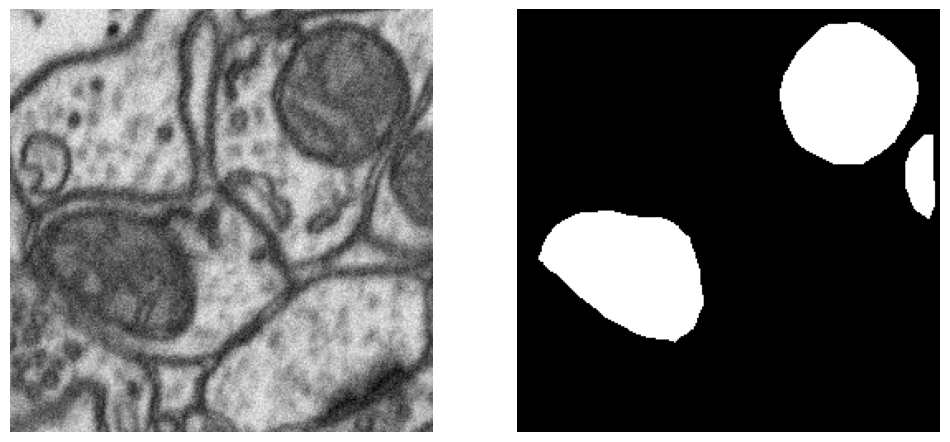

In [ ]:
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.axis('off')
plt.show()

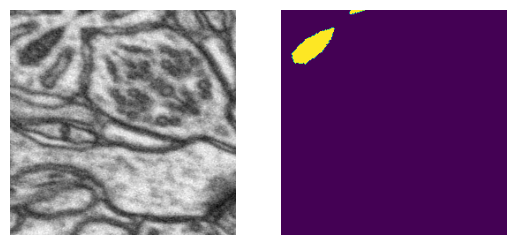

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.axis('off')
    plt.show()

## Model

### Architecture

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
lr=1e-4
epochs=50
height=X_train.shape[1]
width=X_train.shape[2]
steps_per_epoch = 3*(len(X_train))//batch_size


In [ ]:
def conv_block(inputs, filters):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [ ]:
def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = MaxPool2D(2,2)(x)
    return x, p

In [ ]:
def decoder_block(inputs, skip, filters):
    x = Conv2DTranspose(filters, (2,2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

In [ ]:
def UNET(input_shape):

    inputs = Input(input_shape)
    # encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # bridge
    b1 = conv_block(p4, 1024)

    # decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="UNET")
    return model

In [ ]:
input_shape = (height, width, 1)
model = UNET(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                              

### Compile and fit

In [ ]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
model_file = './temp/checkpoint.weights.h5'
log_file = './temp/log.csv'

callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

## Training

In [ ]:
history = model.fit_generator(my_generator, validation_data=validation_datagen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch, epochs=25)

Epoch 1/25


C:\Users\nikhi\AppData\Local\Temp\ipykernel_17340\4049846335.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(my_generator, validation_data=validation_datagen,


108/108 [==============================] - 60s 438ms/step - loss: 0.2705 - accuracy: 0.9350 - val_loss: 0.4091 - val_accuracy: 0.9085
Epoch 2/25
108/108 [==============================] - 46s 429ms/step - loss: 0.1307 - accuracy: 0.9733 - val_loss: 0.3002 - val_accuracy: 0.9051
Epoch 3/25
108/108 [==============================] - 46s 431ms/step - loss: 0.1096 - accuracy: 0.9747 - val_loss: 0.2390 - val_accuracy: 0.9164
Epoch 4/25
108/108 [==============================] - 46s 431ms/step - loss: 0.1024 - accuracy: 0.9751 - val_loss: 0.2275 - val_accuracy: 0.9214
Epoch 5/25
108/108 [==============================] - 47s 440ms/step - loss: 0.0874 - accuracy: 0.9783 - val_loss: 0.2005 - val_accuracy: 0.9200
Epoch 6/25
108/108 [==============================] - 47s 436ms/step - loss: 0.0820 - accuracy: 0.9786 - val_loss: 0.0931 - val_accuracy: 0.9743
Epoch 7/25
108/108 [==============================] - 47s 435ms/step - loss: 0.0699 - accuracy: 0.9818 - val_loss: 0.0657 - val_accuracy: 0.9

### Training Plots

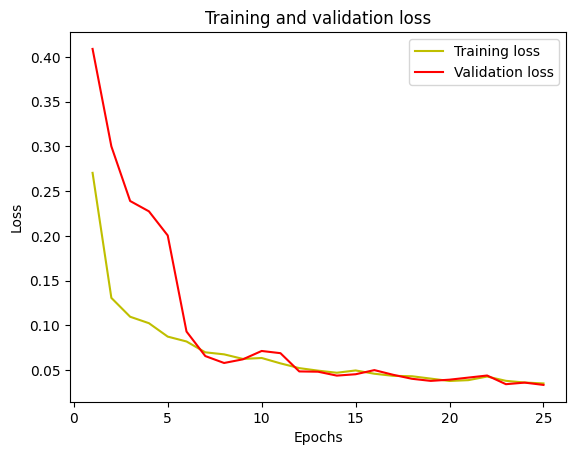

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

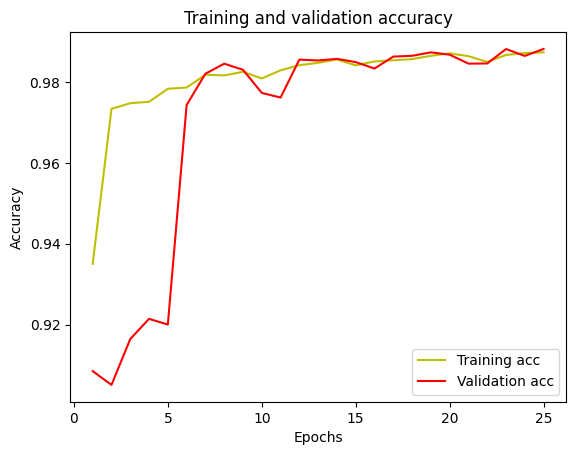

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Prediction

In [ ]:
#IOU
limit = 15
y_pred=model.predict(X_test[0:limit])
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test[0:limit], y_pred_thresholded)
union = np.logical_or(y_test[0:limit], y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 5s 5s/step
IoU socre is:  0.8897667153726004


1/1 [==============================] - 0s 32ms/step


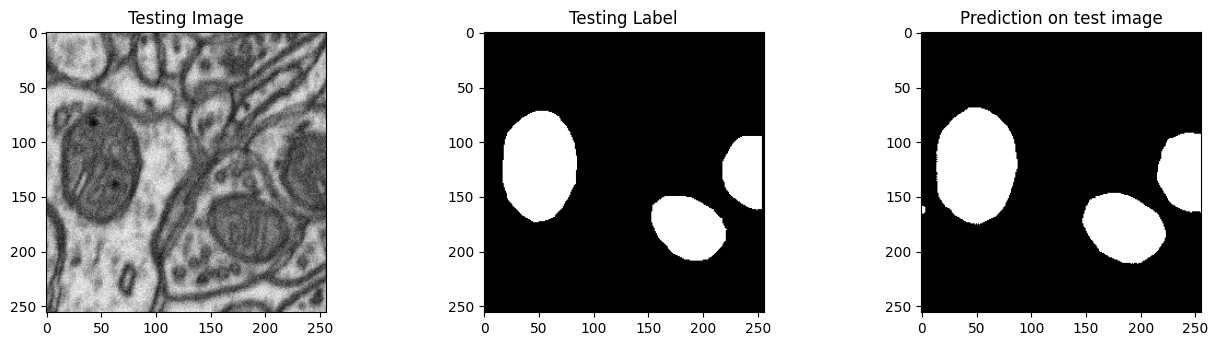

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

## Load and Save Model

In [ ]:
model.save_weights("./../Weights/UNET/train25.weights.h5")


In [ ]:
model2 = UNET(input_shape)
model2.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model2.load_weights("./../Weights/UNET/train25.weights.h5")

In [ ]:
y_pred=model2.predict(X_test[0:limit])
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test[0:limit], y_pred_thresholded)
union = np.logical_or(y_test[0:limit], y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 1s 665ms/step
IoU socre is:  0.8897667153726004
